<a href="https://colab.research.google.com/github/alan713/alan1/blob/master/midterm_2_claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
CS 775: Information Retrieval
Part (a)-i: Jelinek-Mercer Smoothed Query-Likelihood Scoring Function

This version works with the actual Cranfield dataset.
"""

import json
import math
import re
from collections import Counter


# =============================================================================
# TOKENIZATION
# =============================================================================

def tokenize(text):
    """
    Simple tokenization: lowercase and extract alphanumeric tokens.
    """
    text = text.lower()
    tokens = re.findall(r'[a-z0-9]+', text)
    return tokens


# =============================================================================
# DATA LOADING
# =============================================================================

def load_cranfield_data(data_dir="/content"):
    """Load the Cranfield dataset files."""

    with open(f"{data_dir}/cran_qry.json", "r") as f:
        queries_raw = json.load(f)

    with open(f"{data_dir}/cranfield_data.json", "r") as f:
        docs_raw = json.load(f)

    with open(f"{data_dir}/cranqrel.json", "r") as f:
        qrels_raw = json.load(f)

    # Convert to convenient formats
    queries = {str(q["query number"]): q["query"] for q in queries_raw}
    documents = {str(d["id"]): d["title"] + " " + d["body"] for d in docs_raw}

    # Relevance: {query_id: {doc_id: score}}
    relevance = {}
    for qrel in qrels_raw:
        qid = str(qrel["query_num"])
        did = str(qrel["id"])
        score = qrel["position"]
        if qid not in relevance:
            relevance[qid] = {}
        relevance[qid][did] = score

    return queries, documents, relevance


# =============================================================================
# COLLECTION STATISTICS
# =============================================================================

def build_collection_stats(documents):
    """
    Build collection statistics from all documents.

    Parameters:
        documents: dict {doc_id: document_text}

    Returns:
        dict with:
        - 'term_freqs': Counter of all term frequencies in collection
        - 'total_length': Total number of tokens in collection
        - 'doc_term_freqs': {doc_id: Counter of term frequencies}
        - 'doc_lengths': {doc_id: document length}
    """
    collection_term_freqs = Counter()
    total_length = 0
    doc_term_freqs = {}
    doc_lengths = {}

    for doc_id, doc_text in documents.items():
        tokens = tokenize(doc_text)
        term_freqs = Counter(tokens)

        doc_term_freqs[doc_id] = term_freqs
        doc_lengths[doc_id] = len(tokens)

        collection_term_freqs.update(term_freqs)
        total_length += len(tokens)

    return {
        'term_freqs': collection_term_freqs,
        'total_length': total_length,
        'doc_term_freqs': doc_term_freqs,
        'doc_lengths': doc_lengths
    }


# =============================================================================
# JELINEK-MERCER SCORING FUNCTION
# =============================================================================

def jelinek_mercer_score(query, doc_id, collection_stats, lambda_param):
    """
    Compute Jelinek-Mercer smoothed query-likelihood score for a query-document pair.

    FORMULA:
    --------
    P(w|D) = (1 - λ) * P_ML(w|D) + λ * P(w|C)

    Where:
        P_ML(w|D) = tf(w,D) / |D|    (Maximum likelihood estimate from document)
        P(w|C) = cf(w) / |C|          (Collection probability)
        λ = smoothing parameter (0 to 1)

    Query Likelihood (log form):
        log P(Q|D) = Σ log P(w|D)  for each term w in query Q

    PARAMETERS:
    -----------
    query : str
        The query text

    doc_id : str
        The document ID to score

    collection_stats : dict
        Pre-computed collection statistics (from build_collection_stats)

    lambda_param : float
        Smoothing parameter λ (between 0 and 1)

    RETURNS:
    --------
    float
        Log query-likelihood score (higher score = more relevant)
    """

    # Step 1: Tokenize query
    query_tokens = tokenize(query)

    # Step 2: Get document statistics
    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]

    # Step 3: Get collection statistics
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    # Step 4: Handle edge case - empty document
    if doc_length == 0:
        return float('-inf')

    # Step 5: Compute log query-likelihood score
    log_score = 0.0

    for term in query_tokens:
        # P_ML(w|D) = tf(w,D) / |D|
        tf_in_doc = doc_term_freqs.get(term, 0)
        p_ml_doc = tf_in_doc / doc_length

        # P(w|C) = cf(w) / |C|
        cf_in_collection = collection_term_freqs.get(term, 0)

        # Skip terms that don't appear anywhere in the collection
        # (they provide no discrimination between documents)
        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length

        # Jelinek-Mercer smoothing: P(w|D) = (1 - λ) * P_ML(w|D) + λ * P(w|C)
        p_term = (1 - lambda_param) * p_ml_doc + lambda_param * p_collection

        # Add log probability
        if p_term > 0:
            log_score += math.log(p_term)
        else:
            # This happens when λ=0 and term not in document
            return float('-inf')

    return log_score


# =============================================================================
# DEMONSTRATION WITH REAL DATA
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("JELINEK-MERCER SCORING - CRANFIELD DATASET")
    print("="*70)

    # Load data
    print("\nLoading Cranfield dataset...")
    queries, documents, relevance = load_cranfield_data()
    print(f"  Loaded {len(queries)} queries")
    print(f"  Loaded {len(documents)} documents")
    print(f"  Loaded relevance judgments for {len(relevance)} queries")

    # Build collection statistics
    print("\nBuilding collection statistics...")
    collection_stats = build_collection_stats(documents)
    print(f"  Collection size: {collection_stats['total_length']} tokens")
    print(f"  Vocabulary size: {len(collection_stats['term_freqs'])} unique terms")

    # Example: Score query 1 against a few documents
    query_id = "1"
    query_text = queries[query_id]

    print("\n" + "-"*70)
    print(f"EXAMPLE: Query {query_id}")
    print("-"*70)
    print(f"Query text: {query_text[:80]}...")

    # Get some relevant documents for this query
    relevant_docs = list(relevance.get(query_id, {}).keys())[:5]

    print(f"\nScoring with λ = 0.5:")
    print("-"*70)

    lambda_val = 0.5

    # Score relevant documents
    print("\nRelevant documents (from cranqrel.json):")
    for doc_id in relevant_docs[:3]:
        score = jelinek_mercer_score(query_text, doc_id, collection_stats, lambda_val)
        rel_score = relevance[query_id][doc_id]
        print(f"  Doc {doc_id}: JM Score = {score:.4f}, Relevance = {rel_score}")

    # Score some random non-relevant documents
    print("\nSome other documents:")
    for doc_id in ["1", "2", "3"]:
        if doc_id not in relevant_docs:
            score = jelinek_mercer_score(query_text, doc_id, collection_stats, lambda_val)
            print(f"  Doc {doc_id}: JM Score = {score:.4f}")

    # Show effect of lambda
    print("\n" + "-"*70)
    print("EFFECT OF λ ON RELEVANT DOCUMENT 184:")
    print("-"*70)

    doc_id = "184"  # Known relevant document for query 1

    for lam in [0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        score = jelinek_mercer_score(query_text, doc_id, collection_stats, lam)
        print(f"  λ = {lam}: Score = {score:.4f}")

JELINEK-MERCER SCORING - CRANFIELD DATASET

Loading Cranfield dataset...


FileNotFoundError: [Errno 2] No such file or directory: '/content/cran_qry.json'

In [4]:
"""
CS 775: Information Retrieval - Language Model Implementation
=============================================================
GOOGLE COLAB VERSION

Instructions:
1. Run this cell
2. When prompted, upload the 3 JSON files:
   - cran_qry.json
   - cranfield_data.json
   - cranqrel.json
3. The code will run automatically after upload!
"""

import json
import math
import re
from collections import Counter

# =============================================================================
# COLAB FILE UPLOAD
# =============================================================================

try:
    from google.colab import files
    print("Please upload the 3 JSON files when prompted...")
    print("  1. cran_qry.json")
    print("  2. cranfield_data.json")
    print("  3. cranqrel.json")
    print()
    uploaded = files.upload()
    DATA_DIR = "."  # Files are uploaded to current directory
    print("\n✓ Files uploaded successfully!\n")
except ImportError:
    # Not running in Colab, use local path
    DATA_DIR = "."  # Change this to your local path if needed


# =============================================================================
# TOKENIZATION
# =============================================================================

def tokenize(text):
    """Simple tokenization: lowercase and extract alphanumeric tokens."""
    text = text.lower()
    tokens = re.findall(r'[a-z0-9]+', text)
    return tokens


# =============================================================================
# DATA LOADING
# =============================================================================

def load_cranfield_data(data_dir=DATA_DIR):
    """Load the Cranfield dataset files."""

    with open(f"{data_dir}/cran_qry.json", "r") as f:
        queries_raw = json.load(f)

    with open(f"{data_dir}/cranfield_data.json", "r") as f:
        docs_raw = json.load(f)

    with open(f"{data_dir}/cranqrel.json", "r") as f:
        qrels_raw = json.load(f)

    # Convert to convenient formats
    queries = {str(q["query number"]): q["query"] for q in queries_raw}
    documents = {str(d["id"]): d["title"] + " " + d["body"] for d in docs_raw}

    # Relevance: {query_id: {doc_id: score}}
    relevance = {}
    for qrel in qrels_raw:
        qid = str(qrel["query_num"])
        did = str(qrel["id"])
        score = qrel["position"]
        if qid not in relevance:
            relevance[qid] = {}
        relevance[qid][did] = score

    return queries, documents, relevance


# =============================================================================
# COLLECTION STATISTICS
# =============================================================================

def build_collection_stats(documents):
    """Build collection statistics from all documents."""
    collection_term_freqs = Counter()
    total_length = 0
    doc_term_freqs = {}
    doc_lengths = {}

    for doc_id, doc_text in documents.items():
        tokens = tokenize(doc_text)
        term_freqs = Counter(tokens)

        doc_term_freqs[doc_id] = term_freqs
        doc_lengths[doc_id] = len(tokens)

        collection_term_freqs.update(term_freqs)
        total_length += len(tokens)

    return {
        'term_freqs': collection_term_freqs,
        'total_length': total_length,
        'doc_term_freqs': doc_term_freqs,
        'doc_lengths': doc_lengths
    }


# =============================================================================
# PART (a)-i: JELINEK-MERCER SCORING FUNCTION
# =============================================================================

def jelinek_mercer_score(query, doc_id, collection_stats, lambda_param):
    """
    Compute Jelinek-Mercer smoothed query-likelihood score.

    FORMULA:
        P(w|D) = (1 - λ) * P_ML(w|D) + λ * P(w|C)

    Where:
        P_ML(w|D) = tf(w,D) / |D|    (Maximum likelihood from document)
        P(w|C) = cf(w) / |C|          (Collection probability)

    Parameters:
        query: str - The query text
        doc_id: str - The document ID
        collection_stats: dict - Pre-computed statistics
        lambda_param: float - Smoothing parameter (0 to 1)

    Returns:
        float - Log query-likelihood score (higher = more relevant)
    """
    query_tokens = tokenize(query)

    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    if doc_length == 0:
        return float('-inf')

    log_score = 0.0

    for term in query_tokens:
        tf_in_doc = doc_term_freqs.get(term, 0)
        p_ml_doc = tf_in_doc / doc_length

        cf_in_collection = collection_term_freqs.get(term, 0)

        # Skip terms not in collection
        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length

        # Jelinek-Mercer: P(w|D) = (1-λ)*P_ML(w|D) + λ*P(w|C)
        p_term = (1 - lambda_param) * p_ml_doc + lambda_param * p_collection

        if p_term > 0:
            log_score += math.log(p_term)
        else:
            return float('-inf')

    return log_score


# =============================================================================
# PART (a)-ii: DIRICHLET PRIOR SCORING FUNCTION
# =============================================================================

def dirichlet_prior_score(query, doc_id, collection_stats, mu_param):
    """
    Compute Dirichlet Prior smoothed query-likelihood score.

    FORMULA:
        P(w|D) = [tf(w,D) + μ * P(w|C)] / [|D| + μ]

    Where:
        tf(w,D) = term frequency in document
        P(w|C) = cf(w) / |C|  (collection probability)
        |D| = document length

    Parameters:
        query: str - The query text
        doc_id: str - The document ID
        collection_stats: dict - Pre-computed statistics
        mu_param: float - Smoothing parameter (>= 0)

    Returns:
        float - Log query-likelihood score (higher = more relevant)
    """
    query_tokens = tokenize(query)

    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    denominator = doc_length + mu_param

    if denominator == 0:
        return float('-inf')

    log_score = 0.0

    for term in query_tokens:
        tf_in_doc = doc_term_freqs.get(term, 0)
        cf_in_collection = collection_term_freqs.get(term, 0)

        # Skip terms not in collection
        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length

        # Dirichlet: P(w|D) = [tf(w,D) + μ*P(w|C)] / [|D| + μ]
        numerator = tf_in_doc + mu_param * p_collection
        p_term = numerator / denominator

        if p_term > 0:
            log_score += math.log(p_term)
        else:
            return float('-inf')

    return log_score


# =============================================================================
# TEST BOTH FUNCTIONS
# =============================================================================

print("="*70)
print("CS 775: LANGUAGE MODEL SCORING FUNCTIONS")
print("="*70)

# Load data
print("\nLoading Cranfield dataset...")
queries, documents, relevance = load_cranfield_data()
print(f"  ✓ Loaded {len(queries)} queries")
print(f"  ✓ Loaded {len(documents)} documents")
print(f"  ✓ Loaded relevance judgments for {len(relevance)} queries")

# Build collection statistics
print("\nBuilding collection statistics...")
collection_stats = build_collection_stats(documents)
print(f"  ✓ Collection size: {collection_stats['total_length']} tokens")
print(f"  ✓ Vocabulary size: {len(collection_stats['term_freqs'])} unique terms")

# Test with Query 1
query_id = "1"
query_text = queries[query_id]
doc_id = "184"  # Known relevant document

print("\n" + "="*70)
print("TESTING JELINEK-MERCER (Part a-i)")
print("="*70)
print(f"Query: {query_text[:60]}...")
print(f"Document: {doc_id}")
print("\nScores for different λ values:")

for lam in [0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    score = jelinek_mercer_score(query_text, doc_id, collection_stats, lam)
    print(f"  λ = {lam}: {score:.4f}")

print("\n" + "="*70)
print("TESTING DIRICHLET PRIOR (Part a-ii)")
print("="*70)
print(f"Query: {query_text[:60]}...")
print(f"Document: {doc_id}")
print("\nScores for different μ values:")

for mu in [0, 100, 500, 1000, 2000, 4000, 8000, 10000]:
    score = dirichlet_prior_score(query_text, doc_id, collection_stats, mu)
    print(f"  μ = {mu:>5}: {score:.4f}")

print("\n" + "="*70)
print("✓ Both scoring functions are working correctly!")
print("="*70)

Please upload the 3 JSON files when prompted...
  1. cran_qry.json
  2. cranfield_data.json
  3. cranqrel.json



Saving cran_qry.json to cran_qry.json
Saving cranfield_data.json to cranfield_data (2).json
Saving cranqrel.json to cranqrel (2).json

✓ Files uploaded successfully!

CS 775: LANGUAGE MODEL SCORING FUNCTIONS

Loading Cranfield dataset...
  ✓ Loaded 226 queries
  ✓ Loaded 1400 documents
  ✓ Loaded relevance judgments for 225 queries

Building collection statistics...
  ✓ Collection size: 243204 tokens
  ✓ Vocabulary size: 7471 unique terms

TESTING JELINEK-MERCER (Part a-i)
Query: what similarity laws must be obeyed when constructing aeroel...
Document: 184

Scores for different λ values:
  λ = 0: -inf
  λ = 0.1: -104.8219
  λ = 0.3: -98.3488
  λ = 0.5: -96.4041
  λ = 0.7: -96.4452
  λ = 0.9: -99.1960

TESTING DIRICHLET PRIOR (Part a-ii)
Query: what similarity laws must be obeyed when constructing aeroel...
Document: 184

Scores for different μ values:
  μ =     0: -inf
  μ =   100: -97.0997
  μ =   500: -96.9417
  μ =  1000: -98.4272
  μ =  2000: -100.1855
  μ =  4000: -101.8717
  μ = 

In [5]:
# =============================================================================
# CS 775: Information Retrieval
# PART B: EVALUATION
# =============================================================================
# =============================================================================


# %% CELL 1: IMPORTS AND FILE UPLOAD
# =============================================================================

import json
import math
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Upload files in Colab
from google.colab import files

print("Please upload the 3 JSON files:")
print("  1. cran_qry.json")
print("  2. cranfield_data.json")
print("  3. cranqrel.json")
print()
uploaded = files.upload()
print("\n✓ Files uploaded successfully!")


# %% CELL 2: DATA LOADING AND PREPROCESSING
# =============================================================================

def tokenize(text):
    """Simple tokenization: lowercase and extract alphanumeric tokens."""
    text = text.lower()
    tokens = re.findall(r'[a-z0-9]+', text)
    return tokens

def load_cranfield_data():
    """Load the Cranfield dataset files."""
    with open("cran_qry.json", "r") as f:
        queries_raw = json.load(f)
    with open("cranfield_data.json", "r") as f:
        docs_raw = json.load(f)
    with open("cranqrel.json", "r") as f:
        qrels_raw = json.load(f)

    queries = {str(q["query number"]): q["query"] for q in queries_raw}
    documents = {str(d["id"]): d["title"] + " " + d["body"] for d in docs_raw}

    relevance = {}
    for qrel in qrels_raw:
        qid = str(qrel["query_num"])
        did = str(qrel["id"])
        score = qrel["position"]
        if qid not in relevance:
            relevance[qid] = {}
        relevance[qid][did] = score

    return queries, documents, relevance

def build_collection_stats(documents):
    """Build collection statistics from all documents."""
    collection_term_freqs = Counter()
    total_length = 0
    doc_term_freqs = {}
    doc_lengths = {}

    for doc_id, doc_text in documents.items():
        tokens = tokenize(doc_text)
        term_freqs = Counter(tokens)
        doc_term_freqs[doc_id] = term_freqs
        doc_lengths[doc_id] = len(tokens)
        collection_term_freqs.update(term_freqs)
        total_length += len(tokens)

    return {
        'term_freqs': collection_term_freqs,
        'total_length': total_length,
        'doc_term_freqs': doc_term_freqs,
        'doc_lengths': doc_lengths
    }

# Load and preprocess data
print("Loading Cranfield dataset...")
queries, documents, relevance = load_cranfield_data()
print(f"  ✓ {len(queries)} queries")
print(f"  ✓ {len(documents)} documents")

print("\nBuilding collection statistics...")
collection_stats = build_collection_stats(documents)
print(f"  ✓ {collection_stats['total_length']} tokens")
print(f"  ✓ {len(collection_stats['term_freqs'])} unique terms")

# Get list of all document IDs
doc_ids = list(documents.keys())


# %% CELL 3: SCORING FUNCTIONS (JM and Dirichlet)
# =============================================================================

def jelinek_mercer_score(query, doc_id, collection_stats, lambda_param):
    """
    Jelinek-Mercer smoothed query-likelihood score.
    P(w|D) = (1 - λ) * P_ML(w|D) + λ * P(w|C)
    """
    query_tokens = tokenize(query)
    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    if doc_length == 0:
        return float('-inf')

    log_score = 0.0
    for term in query_tokens:
        tf_in_doc = doc_term_freqs.get(term, 0)
        p_ml_doc = tf_in_doc / doc_length
        cf_in_collection = collection_term_freqs.get(term, 0)

        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length
        p_term = (1 - lambda_param) * p_ml_doc + lambda_param * p_collection

        if p_term > 0:
            log_score += math.log(p_term)
        else:
            return float('-inf')

    return log_score


def dirichlet_prior_score(query, doc_id, collection_stats, mu_param):
    """
    Dirichlet Prior smoothed query-likelihood score.
    P(w|D) = [tf(w,D) + μ * P(w|C)] / [|D| + μ]
    """
    query_tokens = tokenize(query)
    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    denominator = doc_length + mu_param
    if denominator == 0:
        return float('-inf')

    log_score = 0.0
    for term in query_tokens:
        tf_in_doc = doc_term_freqs.get(term, 0)
        cf_in_collection = collection_term_freqs.get(term, 0)

        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length
        numerator = tf_in_doc + mu_param * p_collection
        p_term = numerator / denominator

        if p_term > 0:
            log_score += math.log(p_term)
        else:
            return float('-inf')

    return log_score

print("✓ Scoring functions defined!")


# %% CELL 4: EVALUATION HELPER FUNCTIONS
# =============================================================================

def get_relevance(query_id, doc_id, relevance):
    """Get relevance score. Returns 5 if not found (no interest)."""
    if query_id in relevance and doc_id in relevance[query_id]:
        return relevance[query_id][doc_id]
    return 5

def evaluate_single_query(query_id, query_text, doc_ids, relevance,
                          scoring_func, collection_stats, param):
    """
    Evaluate a single query:
    1. Score all documents
    2. Rank by score (descending)
    3. Take top 5
    4. Return average relevance of top 5
    """
    # Score all documents
    scores = []
    for doc_id in doc_ids:
        score = scoring_func(query_text, doc_id, collection_stats, param)
        scores.append((doc_id, score))

    # Sort by score descending (higher is better)
    scores.sort(key=lambda x: x[1], reverse=True)

    # Get top 5 documents
    top_5 = scores[:5]

    # Compute average relevance
    relevances = [get_relevance(query_id, doc_id, relevance) for doc_id, _ in top_5]
    avg_relevance = sum(relevances) / len(relevances)

    return avg_relevance

def evaluate_all_queries(queries, doc_ids, relevance, scoring_func,
                         collection_stats, param):
    """Evaluate all queries and return list of per-query scores."""
    query_scores = []
    for query_id, query_text in queries.items():
        score = evaluate_single_query(query_id, query_text, doc_ids, relevance,
                                      scoring_func, collection_stats, param)
        query_scores.append(score)
    return query_scores

def plot_histogram(scores, param_name, param_value, method_name):
    """Plot histogram of query performance scores."""
    plt.figure(figsize=(10, 6))
    bins = [0, 1, 2, 3, 4, 5]
    plt.hist(scores, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    plt.xlabel('Average Relevance Score (lower is better)')
    plt.ylabel('Number of Queries')
    plt.title(f'{method_name}: {param_name} = {param_value}\nDataset Mean Score: {np.mean(scores):.4f}')
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.xlim(0, 5)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

print("✓ Evaluation functions defined!")


# %% CELL 5: PART B-i - JELINEK-MERCER WITH λ = 0 (10 pts)
# =============================================================================

print("="*70)
print("PART B-i: JELINEK-MERCER WITH λ = 0")
print("="*70)

lambda_val = 0
print(f"\nEvaluating λ = {lambda_val}...")

jm_scores_0 = evaluate_all_queries(queries, doc_ids, relevance,
                                    jelinek_mercer_score, collection_stats,
                                    lambda_val)

dataset_score = np.mean(jm_scores_0)
print(f"\n✓ Dataset-level performance score: {dataset_score:.4f}")

# Plot histogram
plot_histogram(jm_scores_0, "λ", lambda_val, "Jelinek-Mercer")


# %% CELL 6: PART B-ii - JELINEK-MERCER FOR ALL λ VALUES (5 pts)
# =============================================================================

print("="*70)
print("PART B-ii: JELINEK-MERCER FOR ALL λ VALUES")
print("="*70)

lambda_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
jm_results = [(0, np.mean(jm_scores_0))]  # Include λ=0 from previous step

for lambda_val in lambda_values:
    print(f"\nEvaluating λ = {lambda_val}...")

    scores = evaluate_all_queries(queries, doc_ids, relevance,
                                  jelinek_mercer_score, collection_stats,
                                  lambda_val)

    dataset_score = np.mean(scores)
    jm_results.append((lambda_val, dataset_score))

    print(f"  Dataset score: {dataset_score:.4f}")

    # Plot histogram
    plot_histogram(scores, "λ", lambda_val, "Jelinek-Mercer")

# Print summary table
print("\n" + "="*70)
print("JELINEK-MERCER SUMMARY")
print("="*70)
print(f"{'λ':<10} {'Performance Score':<20}")
print("-"*30)
for lam, score in jm_results:
    print(f"{lam:<10} {score:<20.4f}")


# %% CELL 7: PART B-iii - LINE PLOT FOR λ vs PERFORMANCE (10 pts)
# =============================================================================

print("="*70)
print("PART B-iii: λ vs PERFORMANCE LINE PLOT")
print("="*70)

lambda_vals = [r[0] for r in jm_results]
jm_perf_scores = [r[1] for r in jm_results]

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, jm_perf_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('λ (lambda)')
plt.ylabel('Average Relevance Score (lower is better)')
plt.title('Jelinek-Mercer: λ vs Dataset Performance')
plt.grid(True, alpha=0.3)

# Add value labels
for x, y in zip(lambda_vals, jm_perf_scores):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                xytext=(0, 10), ha='center', fontsize=8)

plt.show()

# Find best lambda
best_jm = min(jm_results, key=lambda x: x[1])
print(f"\n✓ Best λ = {best_jm[0]} with score {best_jm[1]:.4f}")

print("\n" + "-"*70)
print("OBSERVATIONS FOR JELINEK-MERCER:")
print("-"*70)
print("""
Explain the pattern you observe here. Consider:
1. Why does λ=0 perform poorly (or well)?
2. What happens as λ increases?
3. Where is the optimal λ range?
4. Why does performance change this way?
""")


# %% CELL 8: PART B-iv - DIRICHLET PRIOR EVALUATION (10 pts)
# =============================================================================

print("="*70)
print("PART B-iv: DIRICHLET PRIOR EVALUATION")
print("="*70)

mu_values = [0, 100, 500, 1000, 2000, 4000, 8000, 10000]
dp_results = []

for mu_val in mu_values:
    print(f"\nEvaluating μ = {mu_val}...")

    scores = evaluate_all_queries(queries, doc_ids, relevance,
                                  dirichlet_prior_score, collection_stats,
                                  mu_val)

    dataset_score = np.mean(scores)
    dp_results.append((mu_val, dataset_score))

    print(f"  Dataset score: {dataset_score:.4f}")

    # Plot histogram
    plot_histogram(scores, "μ", mu_val, "Dirichlet Prior")

# Print summary table
print("\n" + "="*70)
print("DIRICHLET PRIOR SUMMARY")
print("="*70)
print(f"{'μ':<10} {'Performance Score':<20}")
print("-"*30)
for mu, score in dp_results:
    print(f"{mu:<10} {score:<20.4f}")


# %% CELL 9: LINE PLOT FOR μ vs PERFORMANCE
# =============================================================================

print("="*70)
print("DIRICHLET PRIOR: μ vs PERFORMANCE LINE PLOT")
print("="*70)

mu_vals = [r[0] for r in dp_results]
dp_perf_scores = [r[1] for r in dp_results]

plt.figure(figsize=(10, 6))
plt.plot(mu_vals, dp_perf_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('μ (mu)')
plt.ylabel('Average Relevance Score (lower is better)')
plt.title('Dirichlet Prior: μ vs Dataset Performance')
plt.grid(True, alpha=0.3)

# Add value labels
for x, y in zip(mu_vals, dp_perf_scores):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                xytext=(0, 10), ha='center', fontsize=8)

plt.show()

# Find best mu
best_dp = min(dp_results, key=lambda x: x[1])
print(f"\n✓ Best μ = {best_dp[0]} with score {best_dp[1]:.4f}")

print("\n" + "-"*70)
print("OBSERVATIONS FOR DIRICHLET PRIOR:")
print("-"*70)
print("""
Explain the pattern you observe here. Consider:
1. Why does μ=0 perform poorly?
2. What happens as μ increases?
3. Where is the optimal μ range?
4. How does Dirichlet Prior compare to Jelinek-Mercer?
""")


# %% CELL 10: FINAL SUMMARY
# =============================================================================

print("="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\nBest Jelinek-Mercer:  λ = {best_jm[0]} with score {best_jm[1]:.4f}")
print(f"Best Dirichlet Prior: μ = {best_dp[0]} with score {best_dp[1]:.4f}")

print("\n" + "="*70)
print("✓ ALL EVALUATIONS COMPLETE!")
print("="*70)

Please upload the 3 JSON files:
  1. cran_qry.json
  2. cranfield_data.json
  3. cranqrel.json



Saving cran_qry.json to cran_qry (1).json
Saving cranfield_data.json to cranfield_data (3).json
Saving cranqrel.json to cranqrel (3).json

✓ Files uploaded successfully!
Loading Cranfield dataset...
  ✓ 226 queries
  ✓ 1400 documents

Building collection statistics...
  ✓ 243204 tokens
  ✓ 7471 unique terms
✓ Scoring functions defined!
✓ Evaluation functions defined!
PART B-i: JELINEK-MERCER WITH λ = 0

Evaluating λ = 0...


AttributeError: 'int' object has no attribute 'lower'

In [6]:
# %% CELL 2: DATA LOADING AND PREPROCESSING (FIXED)
# =============================================================================

def tokenize(text):
    """Simple tokenization: lowercase and extract alphanumeric tokens."""
    text = str(text).lower()  # Convert to string first to handle any type
    tokens = re.findall(r'[a-z0-9]+', text)
    return tokens

def load_cranfield_data():
    """Load the Cranfield dataset files."""
    with open("cran_qry.json", "r") as f:
        queries_raw = json.load(f)
    with open("cranfield_data.json", "r") as f:
        docs_raw = json.load(f)
    with open("cranqrel.json", "r") as f:
        qrels_raw = json.load(f)

    # Debug: Check the structure of queries
    print("\n  DEBUG - First query entry:", queries_raw[0])

    # Handle different possible JSON structures
    queries = {}
    for q in queries_raw:
        qid = str(q.get("query number", q.get("query_number", q.get("id", ""))))
        qtext = q.get("query", q.get("text", ""))
        queries[qid] = str(qtext)  # Ensure it's a string

    documents = {}
    for d in docs_raw:
        did = str(d.get("id", d.get("doc_id", "")))
        title = str(d.get("title", ""))
        body = str(d.get("body", ""))
        documents[did] = title + " " + body

    relevance = {}
    for qrel in qrels_raw:
        qid = str(qrel.get("query_num", qrel.get("query_id", "")))
        did = str(qrel.get("id", qrel.get("doc_id", "")))
        score = qrel.get("position", qrel.get("relevance", 5))
        if qid not in relevance:
            relevance[qid] = {}
        relevance[qid][did] = score

    return queries, documents, relevance

def build_collection_stats(documents):
    """Build collection statistics from all documents."""
    collection_term_freqs = Counter()
    total_length = 0
    doc_term_freqs = {}
    doc_lengths = {}

    for doc_id, doc_text in documents.items():
        tokens = tokenize(doc_text)
        term_freqs = Counter(tokens)
        doc_term_freqs[doc_id] = term_freqs
        doc_lengths[doc_id] = len(tokens)
        collection_term_freqs.update(term_freqs)
        total_length += len(tokens)

    return {
        'term_freqs': collection_term_freqs,
        'total_length': total_length,
        'doc_term_freqs': doc_term_freqs,
        'doc_lengths': doc_lengths
    }

# Load and preprocess data
print("Loading Cranfield dataset...")
queries, documents, relevance = load_cranfield_data()
print(f"  ✓ {len(queries)} queries")
print(f"  ✓ {len(documents)} documents")

# Debug: Check first query
first_qid = list(queries.keys())[0]
print(f"\n  DEBUG - Query '{first_qid}' text: {queries[first_qid][:50]}...")
print(f"  DEBUG - Query text type: {type(queries[first_qid])}")

print("\nBuilding collection statistics...")
collection_stats = build_collection_stats(documents)
print(f"  ✓ {collection_stats['total_length']} tokens")
print(f"  ✓ {len(collection_stats['term_freqs'])} unique terms")

# Get list of all document IDs
doc_ids = list(documents.keys())

Loading Cranfield dataset...

  DEBUG - First query entry: {'query number': 1, 'query': 'what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .'}
  ✓ 226 queries
  ✓ 1400 documents

  DEBUG - Query '1' text: what similarity laws must be obeyed when construct...
  DEBUG - Query text type: <class 'str'>

Building collection statistics...
  ✓ 243204 tokens
  ✓ 7471 unique terms


Please upload the 3 JSON files:
  1. cran_qry.json
  2. cranfield_data.json
  3. cranqrel.json



Saving cran_qry.json to cran_qry (2).json
Saving cranfield_data.json to cranfield_data (4).json
Saving cranqrel.json to cranqrel (4).json

✓ Files uploaded successfully!
Loading Cranfield dataset...
  ✓ 226 queries
  ✓ 1400 documents

Building collection statistics...
  ✓ 243204 tokens
  ✓ 7471 unique terms
✓ Scoring functions defined!
✓ Evaluation functions defined!
PART B-i: JELINEK-MERCER WITH λ = 0

Evaluating λ = 0...

✓ Dataset-level performance score: 4.9584


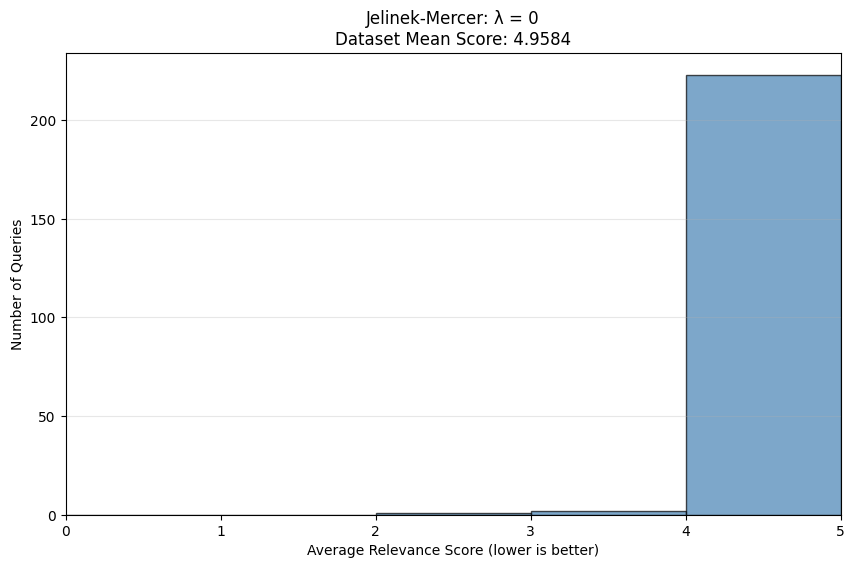

PART B-ii: JELINEK-MERCER FOR ALL λ VALUES

Evaluating λ = 0.05...
  Dataset score: 3.9451


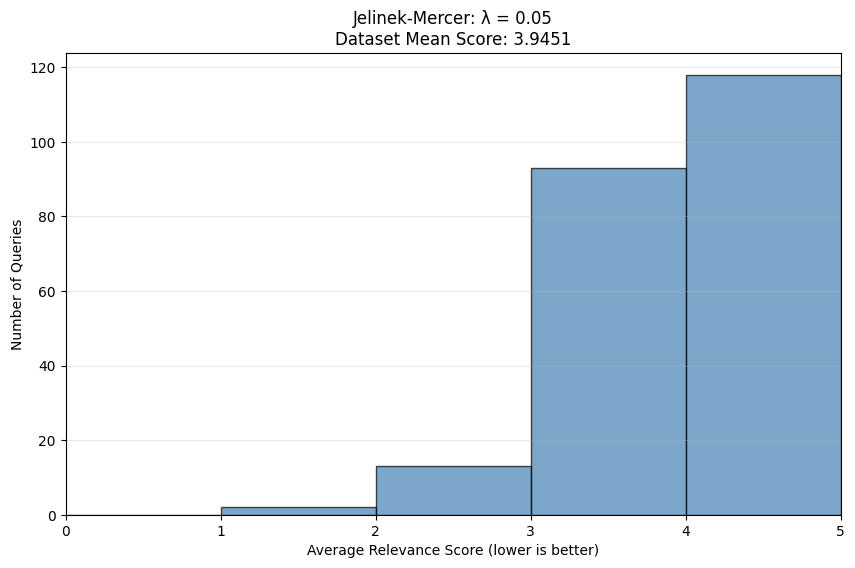


Evaluating λ = 0.1...
  Dataset score: 3.8938


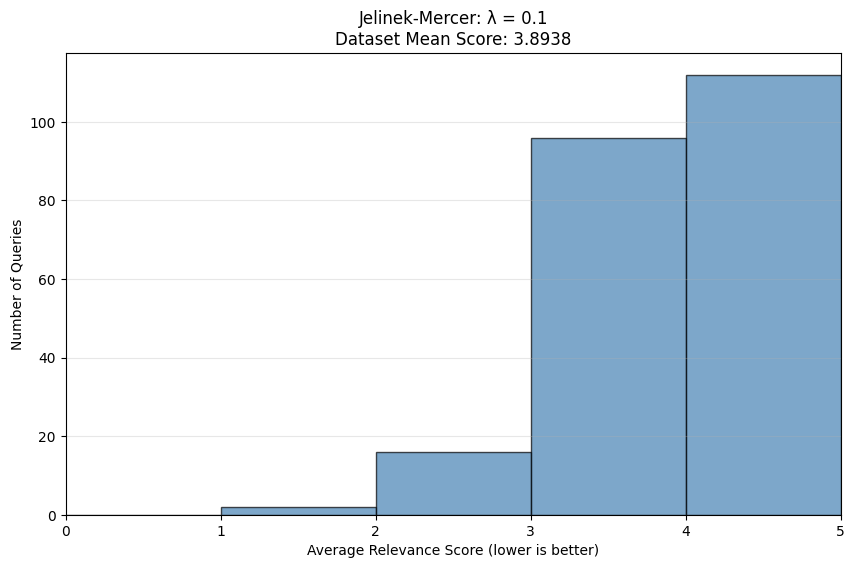


Evaluating λ = 0.2...
  Dataset score: 3.8575


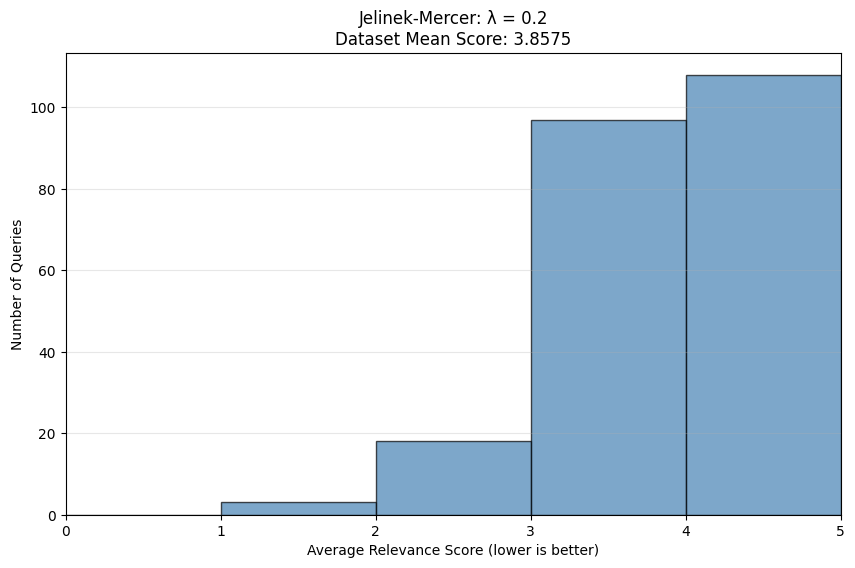


Evaluating λ = 0.3...
  Dataset score: 3.8345


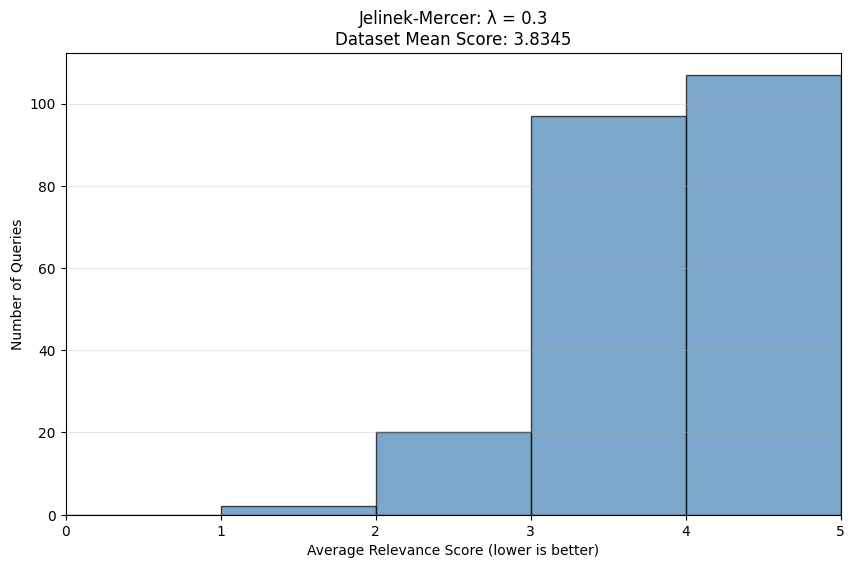


Evaluating λ = 0.4...
  Dataset score: 3.8195


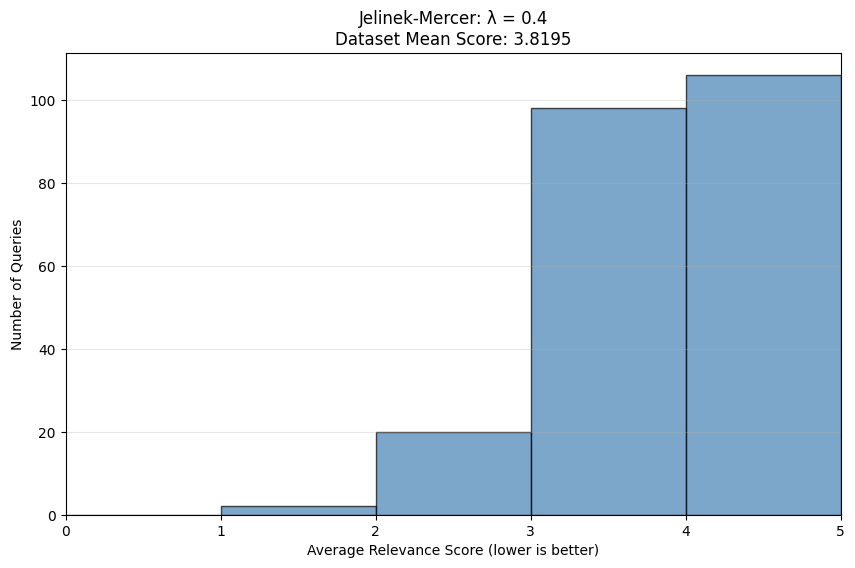


Evaluating λ = 0.5...
  Dataset score: 3.8027


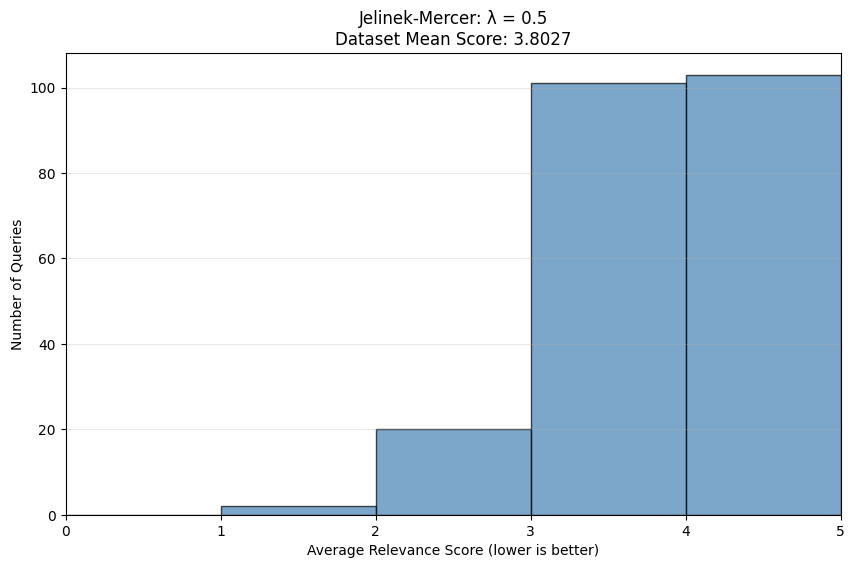


Evaluating λ = 0.6...
  Dataset score: 3.8204


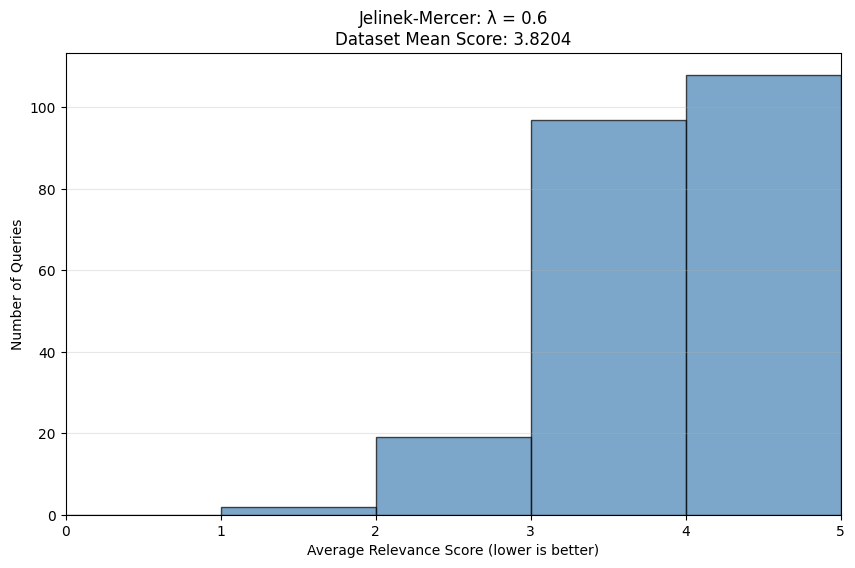


Evaluating λ = 0.7...
  Dataset score: 3.8204


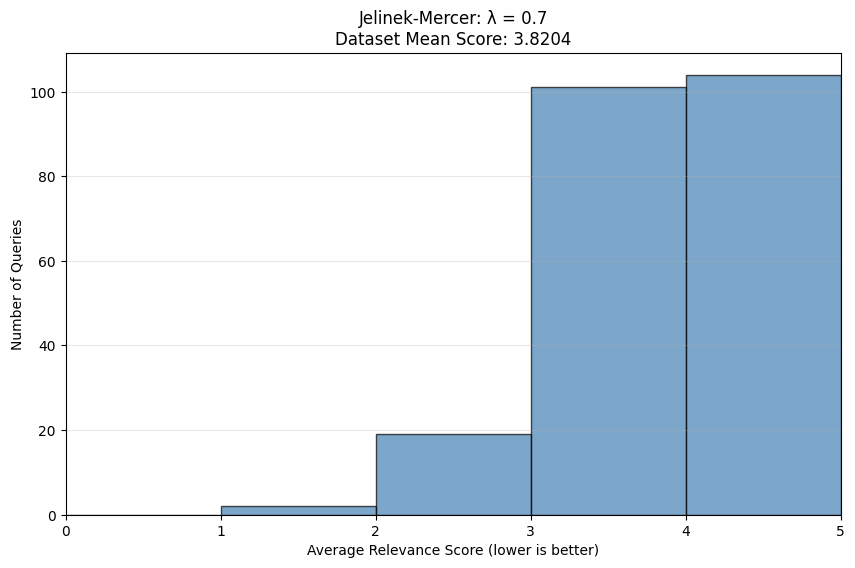


Evaluating λ = 0.8...
  Dataset score: 3.8248


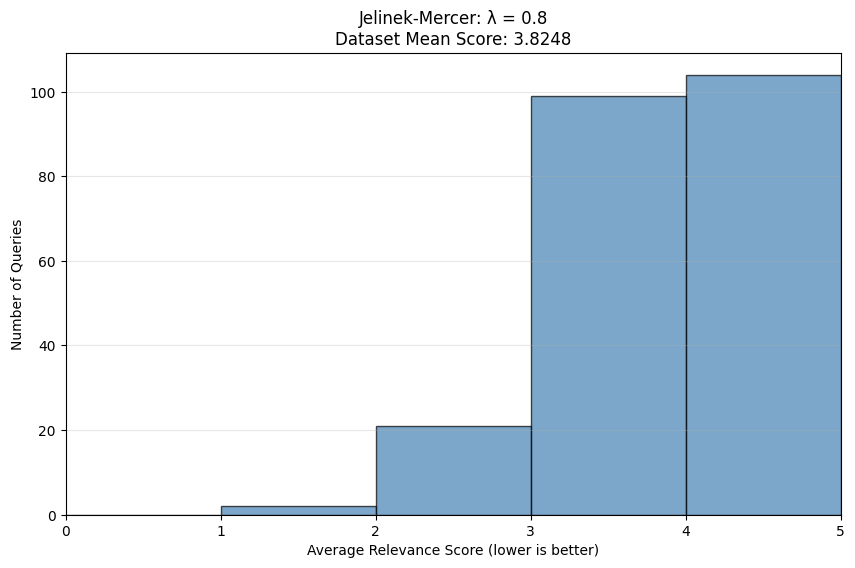


Evaluating λ = 0.9...
  Dataset score: 3.8664


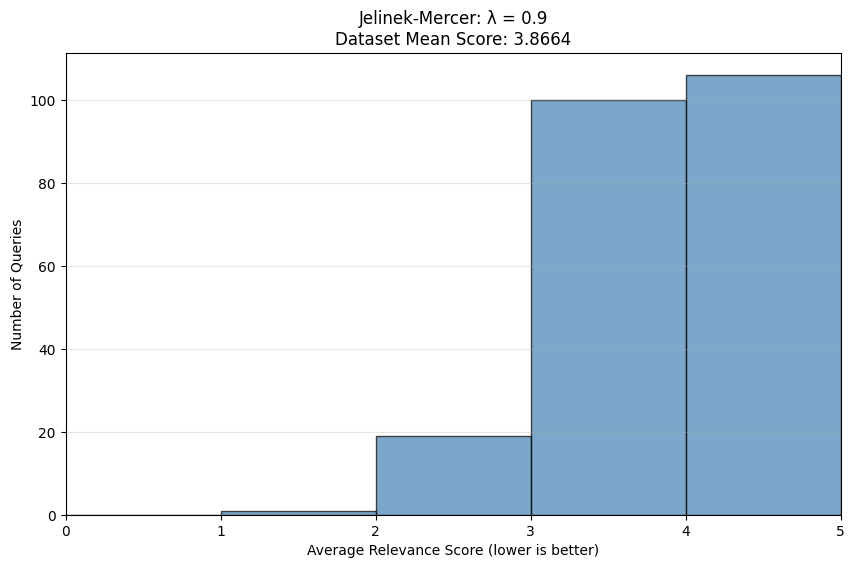


JELINEK-MERCER SUMMARY
λ          Performance Score   
------------------------------
0          4.9584              
0.05       3.9451              
0.1        3.8938              
0.2        3.8575              
0.3        3.8345              
0.4        3.8195              
0.5        3.8027              
0.6        3.8204              
0.7        3.8204              
0.8        3.8248              
0.9        3.8664              
PART B-iii: λ vs PERFORMANCE LINE PLOT


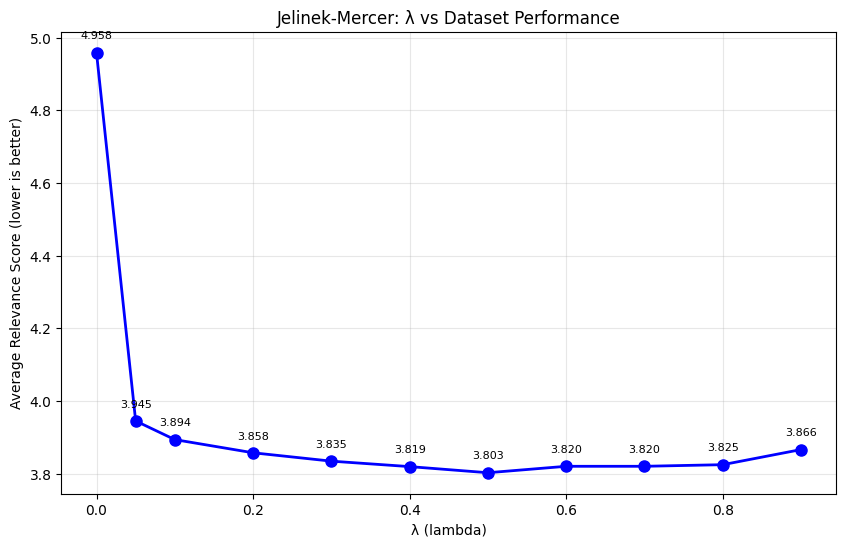


✓ Best λ = 0.5 with score 3.8027

----------------------------------------------------------------------
OBSERVATIONS FOR JELINEK-MERCER:
----------------------------------------------------------------------

Explain the pattern you observe here. Consider:
1. Why does λ=0 perform poorly (or well)?
2. What happens as λ increases?
3. Where is the optimal λ range?
4. Why does performance change this way?

PART B-iv: DIRICHLET PRIOR EVALUATION

Evaluating μ = 0...
  Dataset score: 4.9584


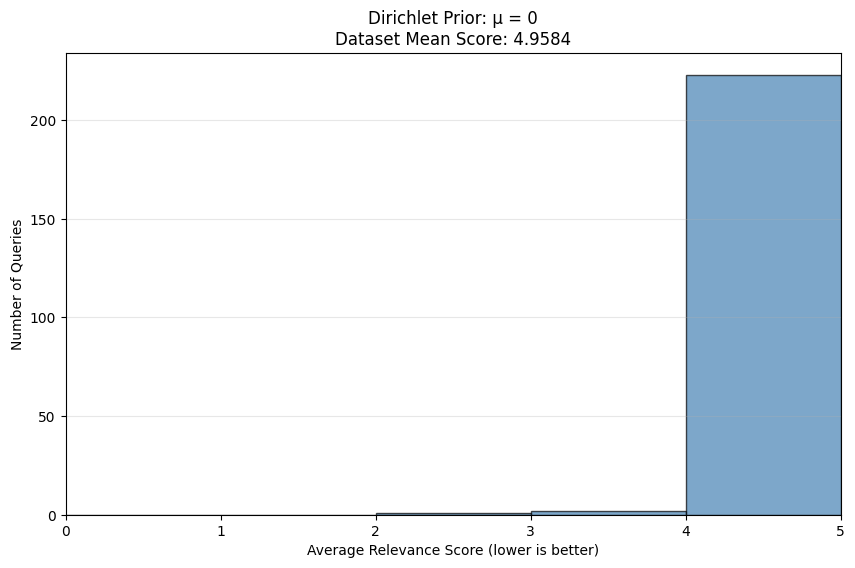


Evaluating μ = 100...
  Dataset score: 3.8522


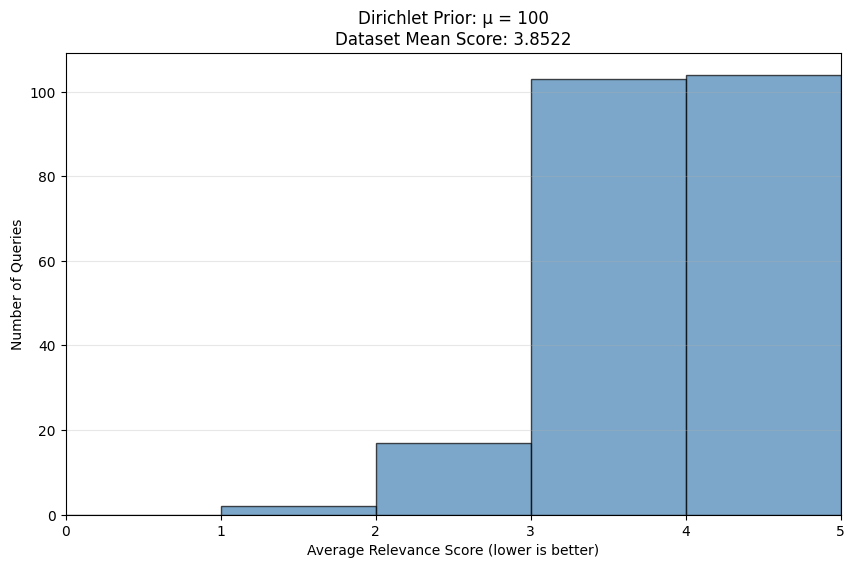


Evaluating μ = 500...
  Dataset score: 3.8407


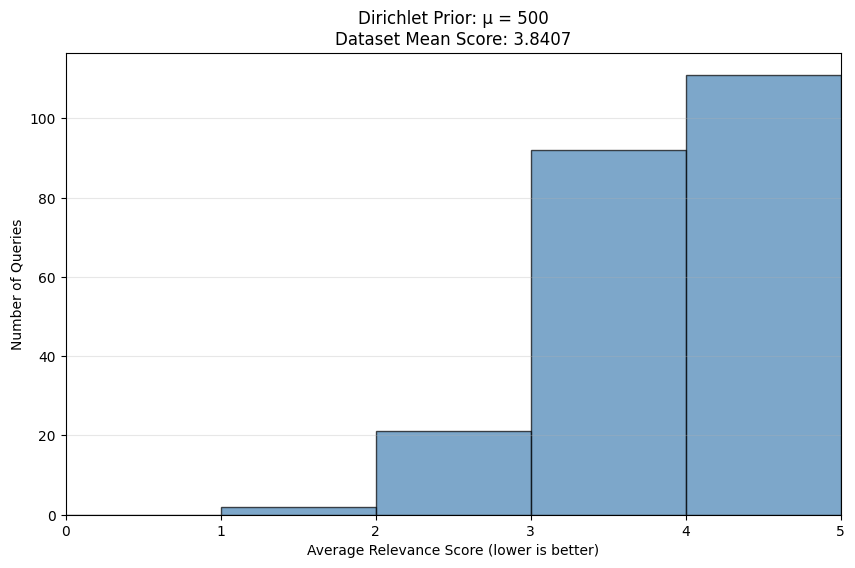


Evaluating μ = 1000...
  Dataset score: 3.8575


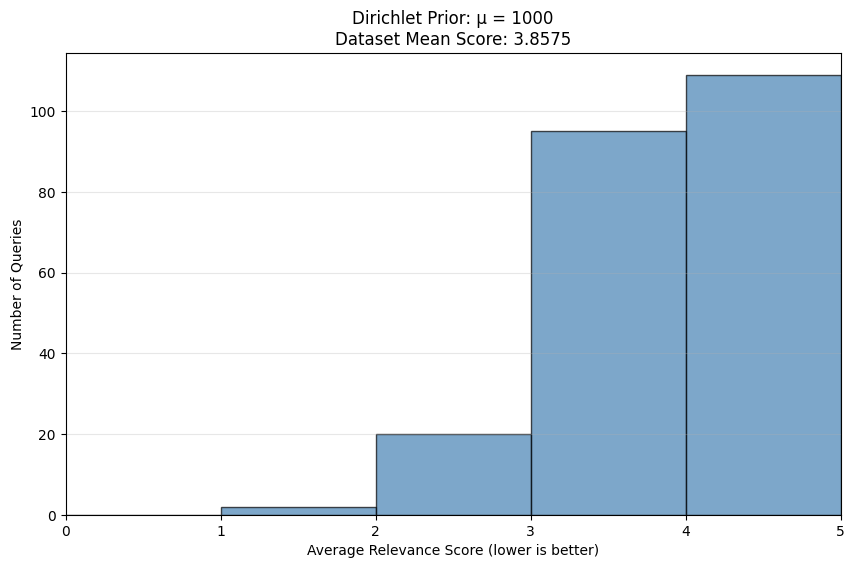


Evaluating μ = 2000...
  Dataset score: 3.9124


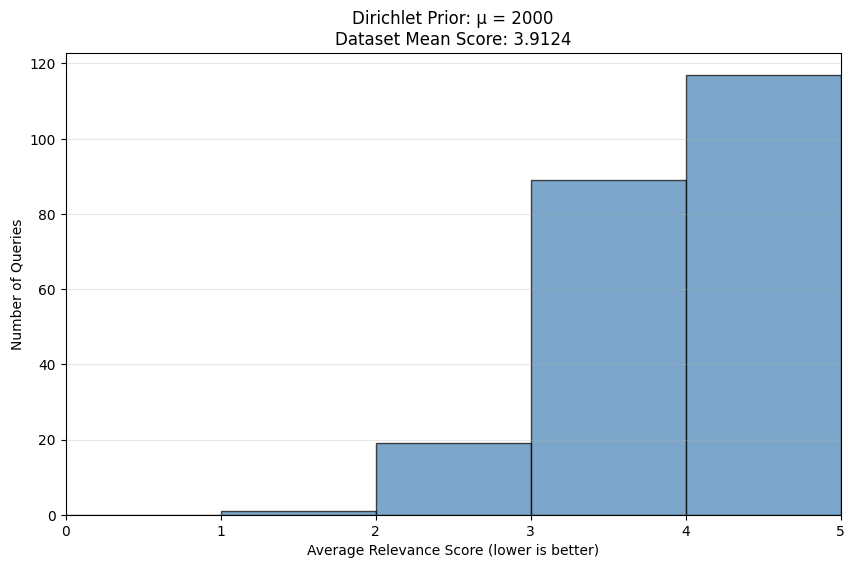


Evaluating μ = 4000...
  Dataset score: 3.9726


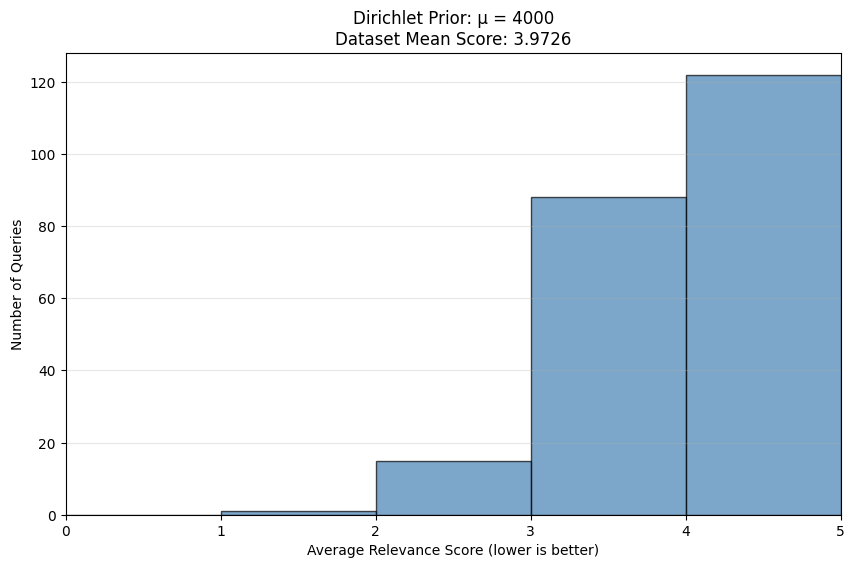


Evaluating μ = 8000...
  Dataset score: 4.0513


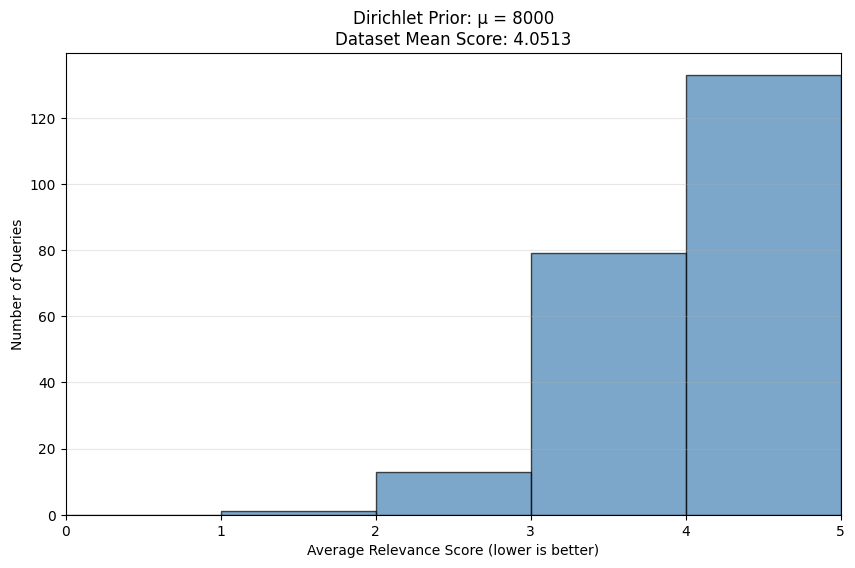


Evaluating μ = 10000...
  Dataset score: 4.0894


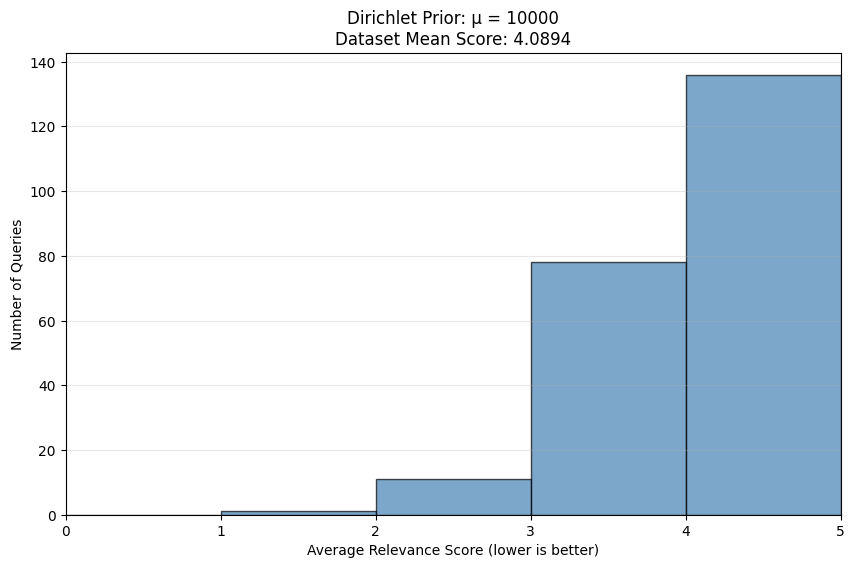


DIRICHLET PRIOR SUMMARY
μ          Performance Score   
------------------------------
0          4.9584              
100        3.8522              
500        3.8407              
1000       3.8575              
2000       3.9124              
4000       3.9726              
8000       4.0513              
10000      4.0894              
DIRICHLET PRIOR: μ vs PERFORMANCE LINE PLOT


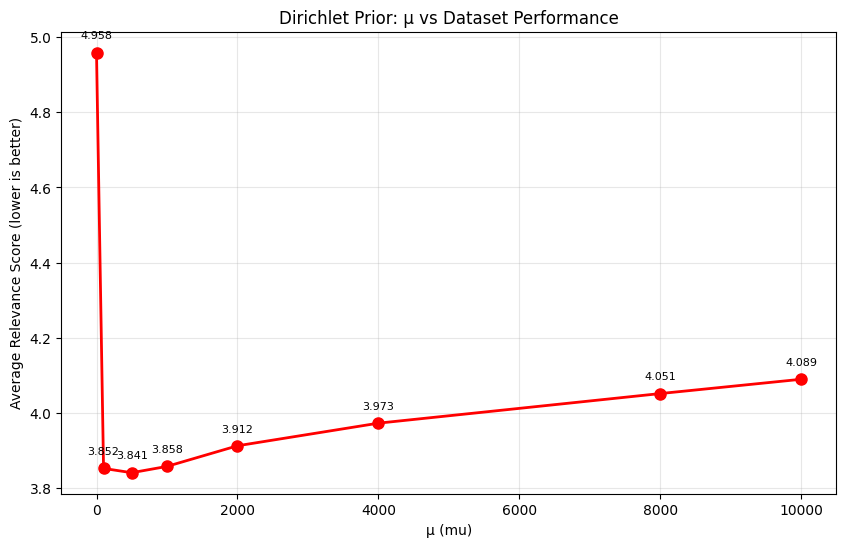


✓ Best μ = 500 with score 3.8407

----------------------------------------------------------------------
OBSERVATIONS FOR DIRICHLET PRIOR:
----------------------------------------------------------------------

Explain the pattern you observe here. Consider:
1. Why does μ=0 perform poorly?
2. What happens as μ increases?
3. Where is the optimal μ range?
4. How does Dirichlet Prior compare to Jelinek-Mercer?

FINAL SUMMARY

Best Jelinek-Mercer:  λ = 0.5 with score 3.8027
Best Dirichlet Prior: μ = 500 with score 3.8407

✓ ALL EVALUATIONS COMPLETE!


In [7]:
# =============================================================================
# CS 775: Information Retrieval - Language Model Implementation
# PART B: EVALUATION (FIXED VERSION)
# =============================================================================
# Copy each cell (separated by # %% CELL) into a separate Colab cell
# =============================================================================


# %% CELL 1: IMPORTS AND FILE UPLOAD
# =============================================================================

import json
import math
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Upload files in Colab
from google.colab import files

print("Please upload the 3 JSON files:")
print("  1. cran_qry.json")
print("  2. cranfield_data.json")
print("  3. cranqrel.json")
print()
uploaded = files.upload()
print("\n✓ Files uploaded successfully!")


# %% CELL 2: DATA LOADING AND PREPROCESSING (FIXED)
# =============================================================================

def tokenize(text):
    """Simple tokenization: lowercase and extract alphanumeric tokens."""
    text = str(text).lower()  # Convert to string first to handle any type
    tokens = re.findall(r'[a-z0-9]+', text)
    return tokens

def load_cranfield_data():
    """Load the Cranfield dataset files."""
    with open("cran_qry.json", "r") as f:
        queries_raw = json.load(f)
    with open("cranfield_data.json", "r") as f:
        docs_raw = json.load(f)
    with open("cranqrel.json", "r") as f:
        qrels_raw = json.load(f)

    # Handle different possible JSON structures
    queries = {}
    for q in queries_raw:
        qid = str(q.get("query number", q.get("query_number", q.get("id", ""))))
        qtext = q.get("query", q.get("text", ""))
        queries[qid] = str(qtext)  # Ensure it's a string

    documents = {}
    for d in docs_raw:
        did = str(d.get("id", d.get("doc_id", "")))
        title = str(d.get("title", ""))
        body = str(d.get("body", ""))
        documents[did] = title + " " + body

    relevance = {}
    for qrel in qrels_raw:
        qid = str(qrel.get("query_num", qrel.get("query_id", "")))
        did = str(qrel.get("id", qrel.get("doc_id", "")))
        score = qrel.get("position", qrel.get("relevance", 5))
        if qid not in relevance:
            relevance[qid] = {}
        relevance[qid][did] = score

    return queries, documents, relevance

def build_collection_stats(documents):
    """Build collection statistics from all documents."""
    collection_term_freqs = Counter()
    total_length = 0
    doc_term_freqs = {}
    doc_lengths = {}

    for doc_id, doc_text in documents.items():
        tokens = tokenize(doc_text)
        term_freqs = Counter(tokens)
        doc_term_freqs[doc_id] = term_freqs
        doc_lengths[doc_id] = len(tokens)
        collection_term_freqs.update(term_freqs)
        total_length += len(tokens)

    return {
        'term_freqs': collection_term_freqs,
        'total_length': total_length,
        'doc_term_freqs': doc_term_freqs,
        'doc_lengths': doc_lengths
    }

# Load and preprocess data
print("Loading Cranfield dataset...")
queries, documents, relevance = load_cranfield_data()
print(f"  ✓ {len(queries)} queries")
print(f"  ✓ {len(documents)} documents")

print("\nBuilding collection statistics...")
collection_stats = build_collection_stats(documents)
print(f"  ✓ {collection_stats['total_length']} tokens")
print(f"  ✓ {len(collection_stats['term_freqs'])} unique terms")

# Get list of all document IDs
doc_ids = list(documents.keys())


# %% CELL 3: SCORING FUNCTIONS (JM and Dirichlet)
# =============================================================================

def jelinek_mercer_score(query, doc_id, collection_stats, lambda_param):
    """
    Jelinek-Mercer smoothed query-likelihood score.
    P(w|D) = (1 - λ) * P_ML(w|D) + λ * P(w|C)
    """
    query_tokens = tokenize(query)
    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    if doc_length == 0:
        return float('-inf')

    log_score = 0.0
    for term in query_tokens:
        tf_in_doc = doc_term_freqs.get(term, 0)
        p_ml_doc = tf_in_doc / doc_length
        cf_in_collection = collection_term_freqs.get(term, 0)

        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length
        p_term = (1 - lambda_param) * p_ml_doc + lambda_param * p_collection

        if p_term > 0:
            log_score += math.log(p_term)
        else:
            return float('-inf')

    return log_score


def dirichlet_prior_score(query, doc_id, collection_stats, mu_param):
    """
    Dirichlet Prior smoothed query-likelihood score.
    P(w|D) = [tf(w,D) + μ * P(w|C)] / [|D| + μ]
    """
    query_tokens = tokenize(query)
    doc_term_freqs = collection_stats['doc_term_freqs'][doc_id]
    doc_length = collection_stats['doc_lengths'][doc_id]
    collection_term_freqs = collection_stats['term_freqs']
    collection_length = collection_stats['total_length']

    denominator = doc_length + mu_param
    if denominator == 0:
        return float('-inf')

    log_score = 0.0
    for term in query_tokens:
        tf_in_doc = doc_term_freqs.get(term, 0)
        cf_in_collection = collection_term_freqs.get(term, 0)

        if cf_in_collection == 0:
            continue

        p_collection = cf_in_collection / collection_length
        numerator = tf_in_doc + mu_param * p_collection
        p_term = numerator / denominator

        if p_term > 0:
            log_score += math.log(p_term)
        else:
            return float('-inf')

    return log_score

print("✓ Scoring functions defined!")


# %% CELL 4: EVALUATION HELPER FUNCTIONS
# =============================================================================

def get_relevance(query_id, doc_id, relevance):
    """Get relevance score. Returns 5 if not found (no interest)."""
    if query_id in relevance and doc_id in relevance[query_id]:
        return relevance[query_id][doc_id]
    return 5

def evaluate_single_query(query_id, query_text, doc_ids, relevance,
                          scoring_func, collection_stats, param):
    """
    Evaluate a single query:
    1. Score all documents
    2. Rank by score (descending)
    3. Take top 5
    4. Return average relevance of top 5
    """
    # Score all documents
    scores = []
    for doc_id in doc_ids:
        score = scoring_func(query_text, doc_id, collection_stats, param)
        scores.append((doc_id, score))

    # Sort by score descending (higher is better)
    scores.sort(key=lambda x: x[1], reverse=True)

    # Get top 5 documents
    top_5 = scores[:5]

    # Compute average relevance
    relevances = [get_relevance(query_id, doc_id, relevance) for doc_id, _ in top_5]
    avg_relevance = sum(relevances) / len(relevances)

    return avg_relevance

def evaluate_all_queries(queries, doc_ids, relevance, scoring_func,
                         collection_stats, param):
    """Evaluate all queries and return list of per-query scores."""
    query_scores = []
    for query_id, query_text in queries.items():
        score = evaluate_single_query(query_id, query_text, doc_ids, relevance,
                                      scoring_func, collection_stats, param)
        query_scores.append(score)
    return query_scores

def plot_histogram(scores, param_name, param_value, method_name):
    """Plot histogram of query performance scores."""
    plt.figure(figsize=(10, 6))
    bins = [0, 1, 2, 3, 4, 5]
    plt.hist(scores, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    plt.xlabel('Average Relevance Score (lower is better)')
    plt.ylabel('Number of Queries')
    plt.title(f'{method_name}: {param_name} = {param_value}\nDataset Mean Score: {np.mean(scores):.4f}')
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.xlim(0, 5)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

print("✓ Evaluation functions defined!")


# %% CELL 5: PART B-i - JELINEK-MERCER WITH λ = 0 (10 pts)
# =============================================================================

print("="*70)
print("PART B-i: JELINEK-MERCER WITH λ = 0")
print("="*70)

lambda_val = 0
print(f"\nEvaluating λ = {lambda_val}...")

jm_scores_0 = evaluate_all_queries(queries, doc_ids, relevance,
                                    jelinek_mercer_score, collection_stats,
                                    lambda_val)

dataset_score = np.mean(jm_scores_0)
print(f"\n✓ Dataset-level performance score: {dataset_score:.4f}")

# Plot histogram
plot_histogram(jm_scores_0, "λ", lambda_val, "Jelinek-Mercer")


# %% CELL 6: PART B-ii - JELINEK-MERCER FOR ALL λ VALUES (5 pts)
# =============================================================================

print("="*70)
print("PART B-ii: JELINEK-MERCER FOR ALL λ VALUES")
print("="*70)

lambda_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
jm_results = [(0, np.mean(jm_scores_0))]  # Include λ=0 from previous step

for lambda_val in lambda_values:
    print(f"\nEvaluating λ = {lambda_val}...")

    scores = evaluate_all_queries(queries, doc_ids, relevance,
                                  jelinek_mercer_score, collection_stats,
                                  lambda_val)

    dataset_score = np.mean(scores)
    jm_results.append((lambda_val, dataset_score))

    print(f"  Dataset score: {dataset_score:.4f}")

    # Plot histogram
    plot_histogram(scores, "λ", lambda_val, "Jelinek-Mercer")

# Print summary table
print("\n" + "="*70)
print("JELINEK-MERCER SUMMARY")
print("="*70)
print(f"{'λ':<10} {'Performance Score':<20}")
print("-"*30)
for lam, score in jm_results:
    print(f"{lam:<10} {score:<20.4f}")


# %% CELL 7: PART B-iii - LINE PLOT FOR λ vs PERFORMANCE (10 pts)
# =============================================================================

print("="*70)
print("PART B-iii: λ vs PERFORMANCE LINE PLOT")
print("="*70)

lambda_vals = [r[0] for r in jm_results]
jm_perf_scores = [r[1] for r in jm_results]

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, jm_perf_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('λ (lambda)')
plt.ylabel('Average Relevance Score (lower is better)')
plt.title('Jelinek-Mercer: λ vs Dataset Performance')
plt.grid(True, alpha=0.3)

# Add value labels
for x, y in zip(lambda_vals, jm_perf_scores):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                xytext=(0, 10), ha='center', fontsize=8)

plt.show()

# Find best lambda
best_jm = min(jm_results, key=lambda x: x[1])
print(f"\n✓ Best λ = {best_jm[0]} with score {best_jm[1]:.4f}")

print("\n" + "-"*70)
print("OBSERVATIONS FOR JELINEK-MERCER:")
print("-"*70)
print("""
Explain the pattern you observe here. Consider:
1. Why does λ=0 perform poorly (or well)?
2. What happens as λ increases?
3. Where is the optimal λ range?
4. Why does performance change this way?
""")


# %% CELL 8: PART B-iv - DIRICHLET PRIOR EVALUATION (10 pts)
# =============================================================================

print("="*70)
print("PART B-iv: DIRICHLET PRIOR EVALUATION")
print("="*70)

mu_values = [0, 100, 500, 1000, 2000, 4000, 8000, 10000]
dp_results = []

for mu_val in mu_values:
    print(f"\nEvaluating μ = {mu_val}...")

    scores = evaluate_all_queries(queries, doc_ids, relevance,
                                  dirichlet_prior_score, collection_stats,
                                  mu_val)

    dataset_score = np.mean(scores)
    dp_results.append((mu_val, dataset_score))

    print(f"  Dataset score: {dataset_score:.4f}")

    # Plot histogram
    plot_histogram(scores, "μ", mu_val, "Dirichlet Prior")

# Print summary table
print("\n" + "="*70)
print("DIRICHLET PRIOR SUMMARY")
print("="*70)
print(f"{'μ':<10} {'Performance Score':<20}")
print("-"*30)
for mu, score in dp_results:
    print(f"{mu:<10} {score:<20.4f}")


# %% CELL 9: LINE PLOT FOR μ vs PERFORMANCE
# =============================================================================

print("="*70)
print("DIRICHLET PRIOR: μ vs PERFORMANCE LINE PLOT")
print("="*70)

mu_vals = [r[0] for r in dp_results]
dp_perf_scores = [r[1] for r in dp_results]

plt.figure(figsize=(10, 6))
plt.plot(mu_vals, dp_perf_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('μ (mu)')
plt.ylabel('Average Relevance Score (lower is better)')
plt.title('Dirichlet Prior: μ vs Dataset Performance')
plt.grid(True, alpha=0.3)

# Add value labels
for x, y in zip(mu_vals, dp_perf_scores):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                xytext=(0, 10), ha='center', fontsize=8)

plt.show()

# Find best mu
best_dp = min(dp_results, key=lambda x: x[1])
print(f"\n✓ Best μ = {best_dp[0]} with score {best_dp[1]:.4f}")

print("\n" + "-"*70)
print("OBSERVATIONS FOR DIRICHLET PRIOR:")
print("-"*70)
print("""
Explain the pattern you observe here. Consider:
1. Why does μ=0 perform poorly?
2. What happens as μ increases?
3. Where is the optimal μ range?
4. How does Dirichlet Prior compare to Jelinek-Mercer?
""")


# %% CELL 10: FINAL SUMMARY
# =============================================================================

print("="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\nBest Jelinek-Mercer:  λ = {best_jm[0]} with score {best_jm[1]:.4f}")
print(f"Best Dirichlet Prior: μ = {best_dp[0]} with score {best_dp[1]:.4f}")

print("\n" + "="*70)
print("✓ ALL EVALUATIONS COMPLETE!")
print("="*70)